In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [9]:
df = pd.read_csv("probe_selection/CNV_NA12878_Average_Probe_Coverage.csv",sep="\t", names=["chrom", "start", "stop", "name", "coverage"])

In [421]:
df[["chrom", "start", "stop"]].to_csv("~/Desktop/orig.bed", sep="\t", header=False, index=False)

In [22]:
df = df.sort_values(["chrom", "start"])

In [511]:
autosomes = ["chr%s" % i for i in range(1,23)]
all_chrs = ["chr%s" % i for i in range(1,23)] + ["chrX", "chrY"]

(0, 1000)

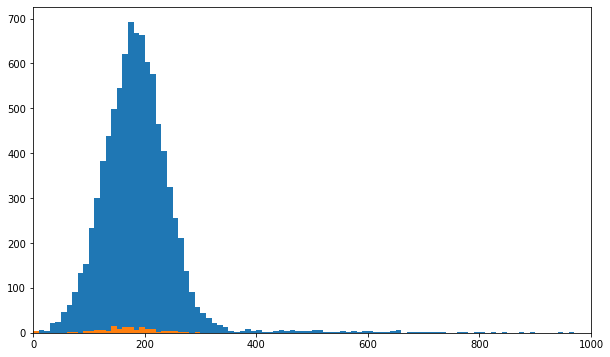

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(df[df.chrom.isin(autosomes)].coverage, bins=100, range=(0,1000))
_ = ax.hist(df[~df.chrom.isin(autosomes)].coverage, bins=100, range=(0,1000))
ax.set_xlim([0,1000])

In [27]:
df["spacing"] = df.groupby("chrom").start.diff()

/Users/nkrumm/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nkrumm/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


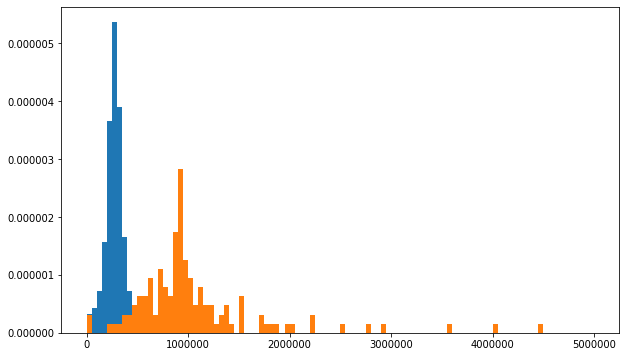

In [46]:

fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(df[df.chrom.isin(autosomes)].spacing, bins=100, range=(0,5e6), normed=True)
_ = ax.hist(df[~df.chrom.isin(autosomes)].spacing, bins=100, range=(0,5e6), normed=True)

## Attempt 2


In [87]:
class Interval():
    def __init__(self, start, end, weight, corresponding_object):
        self.start = start
        self.end = end
        self.weight = weight
        self.corresponding_object = corresponding_object
        # The combined weight of the MWIS prior to this interval.
        self.__value__ = None
        # The previous inverval in the MWIS prior to this interval.
        self.__previous__ = None

    def start_endpoint(self):
        return Endpoint(self, True)

    def end_endpoint(self):
        return Endpoint(self, False)

    def __len__(self):
        return self.end - self.start


class Endpoint():
    def __init__(self, interval, is_start):
        self.interval = interval
        self.is_start = is_start

    def get_idx(self):
        if self.is_start:
            return self.interval.start
        else:
            return self.interval.end

    def __lt__(self, other):
        # This sorts endpont in the following order when offsets are the same:
        # [NI end points][ZI start points][NI start points][ZI end points]
        # NI = Non-zero length interval
        # ZI = Zero length interval
        if self.get_idx() == other.get_idx():
            if len(self.interval) == 0:
                if len(other.interval) == 0:
                    return self.is_start and not other.is_start
                else:
                    return self.is_start and other.is_start
            else:
                if len(other.interval) == 0:
                    return not self.is_start or not other.is_start
                else:
                    return not self.is_start and other.is_start
        else:
            return self.get_idx() < other.get_idx()


def find_maximum_weight_interval_set(intervals):
    """
    Takes a list of weighted intervals and returns a non-overlapping set of them
    with the maximum possible weight.
    Weights may be numeric or numeric tuples.
    There are some edge-cases to consider in determining what constitutes an
    overlap in relation to end-points and zero length intervals.
    The intervals are left-closed. If the left endpoints of two zero
    length intervals overlap, they are considered to be overlapping.
    However, the right endpoint of a non-zero length interval could overlap
    the left endpoint of another interval without it being considered an overlap.
    Of course, if an endpoint is in the middle of another non-zero length
    interval, it is considered to be overlapping.
    """
    endpoints = []
    for interval in intervals:
        endpoints.append(interval.start_endpoint())
        endpoints.append(interval.end_endpoint())
    sorted_endpoints = sorted(endpoints)
    max_interval_sofar = None
    for endpoint in sorted_endpoints:
        if endpoint.is_start:
            endpoint.interval.__value__ = endpoint.interval.weight
            if max_interval_sofar:
                if isinstance(max_interval_sofar.__value__, tuple):
                    endpoint.interval.__value__ = tuple(map(sum, zip(max_interval_sofar.__value__,
                                                                     endpoint.interval.__value__)))
                else:
                    endpoint.interval.__value__ += max_interval_sofar.__value__
                endpoint.interval.__previous__ = max_interval_sofar
        else:  # endoint.is_end
            if not max_interval_sofar:
                max_interval_sofar = endpoint.interval
            elif endpoint.interval.__value__ >= max_interval_sofar.__value__:
                max_interval_sofar = endpoint.interval
    mwis = []
    while max_interval_sofar:
        mwis.insert(0, max_interval_sofar)
        max_interval_sofar = max_interval_sofar.__previous__
    if len(intervals) >= 1:
        assert len(mwis) >= 1
    return mwis

In [542]:
# settings

coverage_penalty = 0
min_spacing = 750000

In [543]:
cov_mean = df.coverage.mean()
out = []
for chrom in all_chrs:
    t = df[df.chrom == chrom]
    t = t.sort_values("start").reset_index()
    ivals = []
    for ix, row in t.iterrows():
        start = row.start - int(min_spacing/2)
        stop = row.stop + int(min_spacing/2)
        abs_delta = abs(cov_mean - row.coverage) * coverage_penalty
        weight = (-1. * abs_delta) + 1000
        row["weight"] = weight
        ivals.append(Interval(start, stop, weight, row))

    mwis = find_maximum_weight_interval_set(ivals)
    mwis_df = pd.DataFrame([i.corresponding_object for i in mwis])
    mwis_df["spacing"] = mwis_df.start.diff()
    out.append(mwis_df)

mwis_df = pd.concat(out)
print(mwis_df.shape[0])

3141


Text(0.5, 0.98, 'Selecting 3141 of 9110 total (min_spacing=700000, penalty=0)')

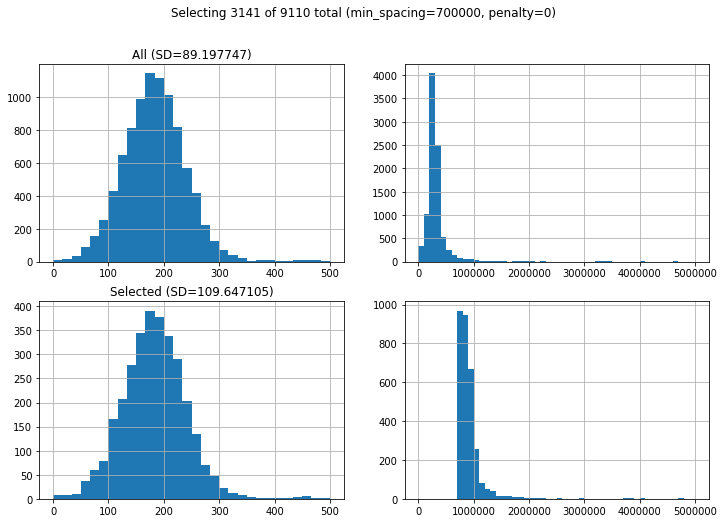

In [544]:
fig, axes = plt.subplots(figsize=(12,8), ncols=2, nrows=2)

df.coverage.hist(bins=30, range=(0,500), ax=axes[0][0])
axes[0][0].set_title("All (SD=%f)" % df.coverage.std())
df.spacing.hist(bins=50, range=(0,5e6), ax=axes[0][1])

mwis_df.coverage.hist(bins=30, range=(0,500), ax=axes[1][0])
axes[1][0].set_title("Selected (SD=%f)" % mwis_df.coverage.std())
mwis_df.spacing.hist(bins=50, range=(0,5e6), ax=axes[1][1])
fig.suptitle("Selecting %d of %d total (min_spacing=%d, penalty=%d)" % (len(mwis_df),len(df), min_spacing, coverage_penalty))

In [545]:
mwis_df[["chrom", "start", "stop"]].to_csv(
    "~/Desktop/selected_%d_%d.bed" % (min_spacing, coverage_penalty),
    sep="\t", header=False, index=False)